<a href="https://colab.research.google.com/github/serafinazhang/Urban-Sound-Classification/blob/main/Urban_Sound_Classification_Code_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Urban Sound Classification with Neural Networks**

# 1 Data Preprcessing

## 1.1 Preparation

In [ ]:
!pip install librosa
import librosa
import librosa.display

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import tarfile
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from google.colab import files
from zipfile import ZipFile

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import pathlib
import csv
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss, classification_report
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Input, TimeDistributed, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, Lambda, GRU, concatenate, Reshape
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import backend
from keras.models import Sequential, Model, load_model
from keras.utils import np_utils
from keras.optimizers import adam_v2

In [ ]:
!pip install h5py

In [ ]:
file = tarfile.open("/content/drive/MyDrive/machine learning/UrbanSound8K.tar.gz")
file.extractall('/content/')

In [ ]:
path = '/content/UrbanSound8K/audio/'
def pre_clean(fold):
  path_list = []
  labels = []
  folds = []
  for i in fold:
    this_path = os.path.join(path,i)
    for root, dirs, files_name in os.walk(this_path):
      files_name.remove('.DS_Store')
      for file in files_name:
        path_list.append(os.path.join(root,file))
        label = file.split('-')[1]
        folds.append(i)
        labels.append(label)
  return path_list, labels, folds

In [ ]:
train_path_list, train_labels, train_folds = pre_clean(train_fold)
test_path_list, test_labels, test_folds = pre_clean(test_fold)

In [ ]:
# get raw data from load function
def loading_raw(path_list):
  raw_list = []
  for i in path_list:
    raw, st = librosa.load(i)
    raw_list.append(raw)
  return raw_list

In [ ]:
train_raw = loading_raw(train_path_list)
test_raw = loading_raw(test_path_list)

In [ ]:
np.array(train_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', 'wb'))
np.array(test_raw,dtype=object).dump(open('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', 'wb'))

In [ ]:
train_label = pd.DataFrame({'fold': train_folds, 'label': train_labels, 'path_list': train_path_list})
test_label = pd.DataFrame({'fold': test_folds, 'label': test_labels, 'path_list': test_path_list})

In [ ]:
train_label.to_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_label.to_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

## 1.2 Data Loading

###1.2.1 Loading Raw

In [ ]:
train_fold = ['fold1', 'fold2', 'fold3', 'fold4', 'fold6']
test_fold = ['fold5', 'fold7', 'fold8', 'fold9', 'fold10']

In [ ]:
train_raw = np.load('/content/drive/MyDrive/machine learning/raw data/train_raw.npy', allow_pickle=True) # sample rate is 22050Hz
test_raw = np.load('/content/drive/MyDrive/machine learning/raw data/test_raw.npy', allow_pickle=True)

In [ ]:
train_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/train_label.csv')
test_meta = pd.read_csv('/content/drive/MyDrive/machine learning/raw data/test_label.csv')

In [ ]:
def extract_name(x):
  l = x.split('/')
  name = l[-1]
  name = name.split('.')[0]
  return name

In [ ]:
train_meta['name'] = train_meta['path_list'].apply(extract_name)
test_meta['name'] = test_meta['path_list'].apply(extract_name)

In [ ]:
valid_raw = test_raw[:936]
test_raw = test_raw[936:]

In [ ]:
valid_meta = test_meta[:936]

In [ ]:
test_meta = test_meta[936:].reset_index()

###1.2.2 Slicing

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

In [ ]:
def re_split(raw_data, meta_data, frames = 41):
  column_names = ['name', 'fold', "label"]
  df = pd.DataFrame(columns=column_names)
  array_list = []

  window_size = 512 * (frames - 1)
  for i in range(len(raw_data)):
    sound_clip = raw_data[i]

    for (start,end) in windows(sound_clip,window_size):
      if(len(sound_clip[int(start):int(end)]) == int(window_size)):
        signal = sound_clip[int(start):int(end)]
        array_list.append(signal)
        df = df.append({'name': meta_data['name'][i], 'fold': meta_data['fold'][i], 'label': meta_data['label'][i]}, ignore_index = True)

  return np.array(array_list), df

In [ ]:
train_raw_split, train_meta_split = re_split(train_raw, train_meta)
test_raw_split, test_meta_split = re_split(test_raw, test_meta)
valid_raw_split, valid_meta_split = re_split(valid_raw, valid_meta)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/train_raw_split.npy', train_raw_split)
np.save('/content/drive/MyDrive/machine learning/test_raw_split.npy', test_raw_split)
np.save('/content/drive/MyDrive/machine learning/valid_raw_split.npy', valid_raw_split)

In [ ]:
train_meta_split.to_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split.to_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split.to_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

In [ ]:
train_raw_split = np.load('/content/drive/MyDrive/machine learning/train_raw_split.npy') 
test_raw_split = np.load('/content/drive/MyDrive/machine learning/test_raw_split.npy')
valid_raw_split = np.load('/content/drive/MyDrive/machine learning/valid_raw_split.npy')

In [ ]:
train_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/train_meta_split.csv')
test_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/test_meta_split.csv')
valid_meta_split = pd.read_csv('/content/drive/MyDrive/machine learning/valid_meta_split.csv')

In [ ]:
test_meta_split[test_meta_split['label']==7]

,Unnamed: 0,name,fold,label
154,154,177537-7-0-7,fold7,7
155,155,177537-7-0-7,fold7,7
156,156,177537-7-0-7,fold7,7
157,157,177537-7-0-7,fold7,7
158,158,177537-7-0-7,fold7,7
...,...,...,...,...
20500,20500,162134-7-13-0,fold10,7
20501,20501,162134-7-13-0,fold10,7
20502,20502,162134-7-13-0,fold10,7
20503,20503,162134-7-13-0,fold10,7


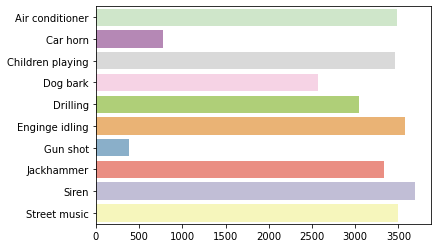

In [ ]:
ax = sns.countplot(y='label', data=train_meta_split, palette="Set3_r")
ax.set_yticklabels(['Air conditioner', 'Car horn', 'Children playing', 'Dog bark', 'Drilling', 'Enginge idling', 'Gun shot', 'Jackhammer', 'Siren', 'Street music'])
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.figure
plt.savefig('label_distribution.eps', bbox_inches='tight', pad_inches=0.0)

In [ ]:
dis = pd.DataFrame({'Data': ['Training', 'Validation', 'Test'], 'Count': [27809, 5689, 20555]})

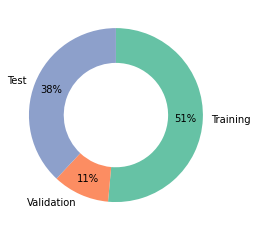

In [ ]:
ax = sns.set_palette('Set2')
plt.pie(dis['Count'], startangle = 90, counterclock = False, wedgeprops = {'width': 0.4}, autopct='%1.0f%%', pctdistance=0.8, labels = dis['Data'])
plt.figure
plt.savefig('dis.eps', bbox_inches='tight', pad_inches=0.0)

## 1.3 Data Visualization

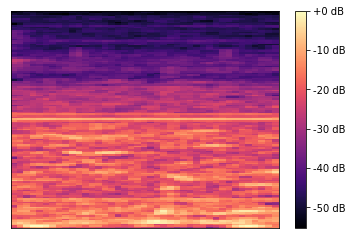

In [ ]:
signal = train_raw_split[13148]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label0.eps', bbox_inches='tight', pad_inches=0.0)

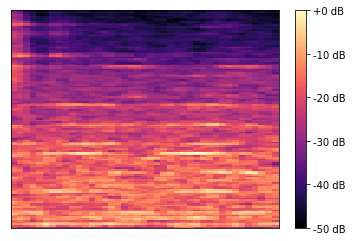

In [ ]:
signal = train_raw_split[18466]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label1.eps', bbox_inches='tight', pad_inches=0.0)

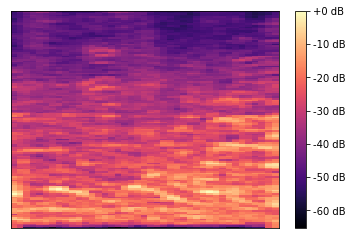

In [ ]:
signal = train_raw_split[15]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label2.eps', bbox_inches='tight', pad_inches=0.0)

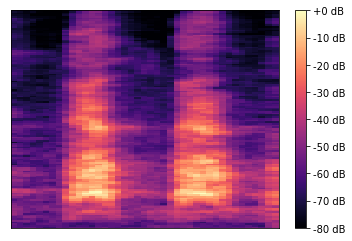

In [ ]:
signal = train_raw_split[20113]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label3.eps', bbox_inches='tight', pad_inches=0.0)

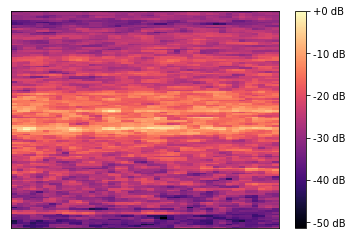

In [ ]:
signal = train_raw_split[7]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label4.eps', bbox_inches='tight', pad_inches=0.0)

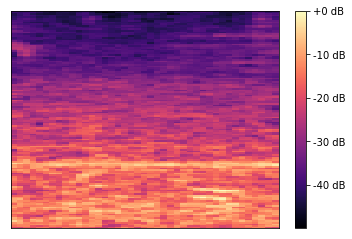

In [ ]:
signal = train_raw_split[27774]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label5.eps', bbox_inches='tight', pad_inches=0.0)

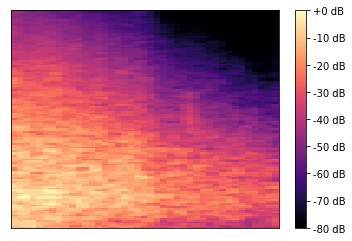

In [ ]:
signal = train_raw_split[597]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label6.eps', bbox_inches='tight', pad_inches=0.0)

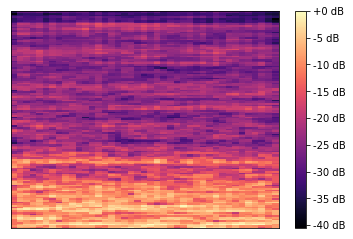

In [ ]:
signal = train_raw_split[53]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label7.eps', bbox_inches='tight', pad_inches=0.0)

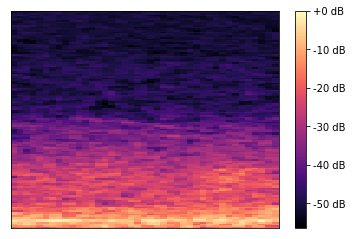

In [ ]:
signal = train_raw_split[68]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label8.eps', bbox_inches='tight', pad_inches=0.0)

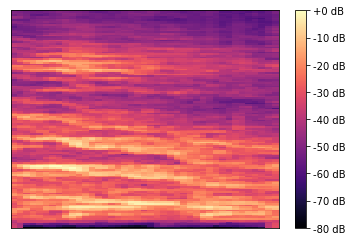

In [ ]:
signal = train_raw_split[374]
S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.figure
plt.savefig('label9.eps', bbox_inches='tight', pad_inches=0.0)

## 1.4 Feature Extraction

In [ ]:
def mel_data(raw_data):
  mel_fre = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mel_fre.append(f)
  mel_fre = np.asarray(mel_fre).reshape(len(raw_data),41,128)
  return mel_fre

In [ ]:
def mfcc_data(raw_data):
  mfcc = []
  for i in range(len(raw_data)): 
    signal = raw_data[i] 
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    S_dB = librosa.power_to_db(S, ref=np.max).T
    f = S_dB.flatten()
    mfcc.append(f)
  mfcc = np.asarray(mfcc).reshape(len(raw_data),41,50) 
  return mfcc

In [ ]:
def chroma_data(raw_data):
  chroma_d = []
  for i in range(len(raw_data)):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal).T
    f = chroma.flatten()
    chroma_d.append(f)
  chroma_d = np.asarray(chroma_d).reshape(len(raw_data),41,12) 
  return chroma_d

In [ ]:
mel_train_data = mel_data(train_raw_split) 
mel_valid_data = mel_data(valid_raw_split)
mel_test_data = mel_data(test_raw_split) 

In [ ]:
mfcc_train_data = mfcc_data(train_raw_split)
mfcc_valid_data = mfcc_data(valid_raw_split) 
mfcc_test_data = mfcc_data(test_raw_split)

In [ ]:
chroma_train_data = chroma_data(train_raw_split)
chroma_valid_data = chroma_data(valid_raw_split) 
chroma_test_data = chroma_data(test_raw_split)

In [ ]:
all_feature_train = np.concatenate((mel_train_data, mfcc_train_data, chroma_train_data), axis = 2) 
all_feature_valid = np.concatenate((mel_valid_data, mfcc_valid_data, chroma_valid_data), axis = 2)
all_feature_test = np.concatenate((mel_test_data, mfcc_test_data, chroma_test_data), axis = 2)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_feature_train.npy', all_feature_train) 
np.save('/content/drive/MyDrive/machine learning/all_feature_valid.npy', all_feature_valid)
np.save('/content/drive/MyDrive/machine learning/all_feature_test.npy', all_feature_test)

## 1.5 Image Generation

In [ ]:
# load Image function
def load_image(meta_data, save_path):
  image_array = []

  for i in range(len(meta_data)):
    p = save_path + meta_data['name'][i] + '-' + str(i) + '.png'
    p = pathlib.Path(p)
    a = img_to_array(load_img(p, target_size=(32, 32)))
    image_array.append(a)
  return np.array(image_array)

### 1.5.1 Mel-frequency Spectrogram

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/melspectrogram_test').mkdir(parents=True, exist_ok=True)

In [ ]:
mel_train_path = '/content/drive/MyDrive/machine learning/melspectrogram_train/'
mel_valid_path = '/content/drive/MyDrive/machine learning/melspectrogram_valid/'
mel_test_path = '/content/drive/MyDrive/machine learning/melspectrogram_test/'

In [ ]:
def mel_spect(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    S = librosa.feature.melspectrogram(signal, n_mels = 128, fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

In [ ]:
mel_spect(test_raw_split, test_meta_split, 'fold7', mel_test_path)  

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/melspectrogram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
mel_train_img = '/content/melspectrogram_train/'
mel_train_array = load_image(train_meta_split, mel_train_img)  

In [ ]:
mel_valid_img = '/content/melspectrogram_valid/'
mel_valid_array = load_image(valid_meta_split, mel_valid_img)  

In [ ]:
mel_test_img = '/content/melspectrogram_test/'
mel_test_array = load_image(test_meta_split, mel_test_img)  

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mel_train_array.npy', mel_train_array)
np.save('/content/drive/MyDrive/machine learning/mel_test_array.npy', mel_test_array) 
np.save('/content/drive/MyDrive/machine learning/mel_valid_array.npy', mel_valid_array) 

### 1.5.2 MFCCs Plot

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_valid').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/mfcc_plot_test').mkdir(parents=True, exist_ok=True)

In [ ]:
mfcc_train_path = '/content/drive/MyDrive/machine learning/mfcc_plot_train/'
mfcc_valid_path = '/content/drive/MyDrive/machine learning/mfcc_plot_valid/'
mfcc_test_path = '/content/drive/MyDrive/machine learning/mfcc_plot_test/'

In [ ]:
def mfcc_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]   
    S = librosa.feature.mfcc(y=signal, n_mfcc=50)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)
    plt.clf()
    plt.close()

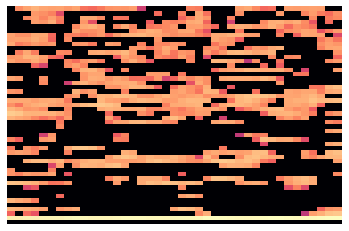

In [ ]:

signal = train_raw_split[20113]
S = librosa.feature.mfcc(y=signal, n_mfcc=50)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB,fmax=8000, ax=ax)
plt.axis('off')
plt.savefig('mfcc_0.eps', bbox_inches='tight', pad_inches=0.0)

In [ ]:
mfcc_plot(train_raw_split, train_meta_split, 'fold1', mfcc_train_path)

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_valid.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_train.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/mfcc_plot_test.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
mfcc_train_img = '/content/mfcc_plot_train/'
mfcc_train_array = load_image(train_meta_split, mfcc_train_img)

In [ ]:
mfcc_valid_img = '/content/mfcc_plot_valid/'
mfcc_valid_array = load_image(valid_meta_split, mfcc_valid_img)

In [ ]:
mfcc_test_img = '/content/mfcc_plot_test/'
mfcc_test_array = load_image(test_meta_split, mfcc_test_img)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/mfcc_train_array.npy', mfcc_train_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_test_array.npy', mfcc_test_array)
np.save('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy', mfcc_valid_array)

### 1.5.3 Chromagram

In [ ]:
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_train').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_test').mkdir(parents=True, exist_ok=True)
pathlib.Path(f'/content/drive/MyDrive/machine learning/chromagram_valid').mkdir(parents=True, exist_ok=True)

In [ ]:
chroma_train_path = '/content/drive/MyDrive/machine learning/chromagram_train/'
chroma_valid_path = '/content/drive/MyDrive/machine learning/chromagram_valid/'
chroma_test_path = '/content/drive/MyDrive/machine learning/chromagram_test/'

In [ ]:
def chromagram_plot(raw_data, meta, fold_name, save_path):
  for i in list(meta[meta['fold']==fold_name].index):
    signal = raw_data[i]
    chroma = librosa.feature.chroma_stft(y=signal)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(chroma, ax= ax)
    plt.axis('off')
    name = save_path + meta['name'][i] + '-' + str(i)
    plt.savefig('{}.png'.format(name), bbox_inches='tight', pad_inches=0.0)       
    plt.clf()
    plt.close()

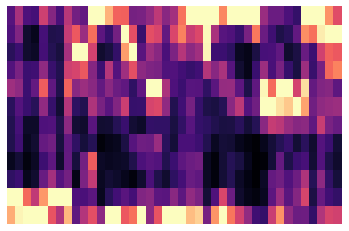

In [ ]:
signal = train_raw_split[20113]
chroma = librosa.feature.chroma_stft(y=signal)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, ax= ax)
plt.figure
plt.axis('off')
plt.savefig('chroma_0.eps', bbox_inches='tight', pad_inches=0.0)

In [ ]:
chromagram_plot(train_raw_split, train_meta_split, 'fold1', chroma_train_path) 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_valid.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_train.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
with ZipFile('/content/drive/MyDrive/machine learning/chromagram_test.zip', 'r') as zipObj:
  zipObj.extractall() 

In [ ]:
chroma_train_img = '/content/chromagram_train/'
chroma_train_array = load_image(train_meta_split, chroma_train_img) 

In [ ]:
chroma_valid_img = '/content/chromagram_valid/'
chroma_valid_array = load_image(valid_meta_split, chroma_valid_img) 

In [ ]:
chroma_test_img = '/content/chromagram_test/'
chroma_test_array = load_image(test_meta_split, chroma_test_img) 

In [ ]:
np.save('/content/drive/MyDrive/machine learning/chroma_train_array.npy', chroma_train_array) 
np.save('/content/drive/MyDrive/machine learning/chroma_test_array.npy', chroma_test_array) 
np.save('/content/drive/MyDrive/machine learning/chroma_valid_array.npy', chroma_valid_array) 

### 1.5.4 Combined Image

In [ ]:
mel_train_array = np.load('/content/drive/MyDrive/machine learning/mel_train_array.npy')
mel_test_array = np.load('/content/drive/MyDrive/machine learning/mel_test_array.npy')
mel_valid_array = np.load('/content/drive/MyDrive/machine learning/mel_valid_array.npy')

In [ ]:
mfcc_train_array = np.load('/content/drive/MyDrive/machine learning/mfcc_train_array.npy')
mfcc_test_array = np.load('/content/drive/MyDrive/machine learning/mfcc_test_array.npy')
mfcc_valid_array = np.load('/content/drive/MyDrive/machine learning/mfcc_valid_array.npy')

In [ ]:
chroma_train_array = np.load('/content/drive/MyDrive/machine learning/chroma_train_array.npy')
chroma_test_array = np.load('/content/drive/MyDrive/machine learning/chroma_test_array.npy')
chroma_valid_array = np.load('/content/drive/MyDrive/machine learning/chroma_valid_array.npy')

In [ ]:
def img_combine(mel_array, mfcc_array, chroma_array):
  array_new = np.concatenate((mel_array[:,:,:,0][:,:,:,np.newaxis], mfcc_array[:,:,:,1][:,:,:,np.newaxis],chroma_array[:,:,:,2][:,:,:,np.newaxis]), axis =3)
  return array_new

In [ ]:
train_meta_split.iloc[20113,:]

Unnamed: 0        20113
name          344-3-5-0
fold              fold4
label                 3
Name: 20113, dtype: object

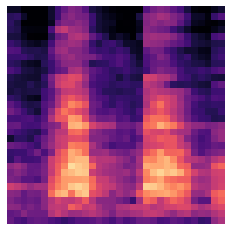

In [ ]:
plt.imshow(mel_train_array[20113].astype('float32')/255)
plt.axis('off')
plt.figure
plt.savefig('melspect.eps', bbox_inches='tight', pad_inches=0.0)

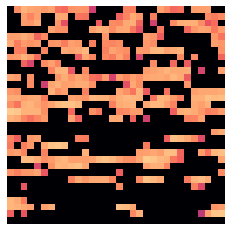

In [ ]:
plt.imshow(mfcc_train_array[20113].astype('float32')/255)
plt.axis('off')
plt.figure
plt.savefig('mfcc.eps', bbox_inches='tight', pad_inches=0.0)

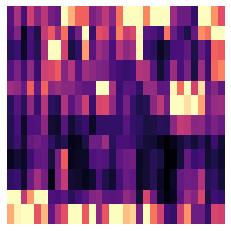

In [ ]:
plt.imshow(chroma_train_array[20113].astype('float32')/255)
plt.axis('off')
plt.figure
plt.savefig('chroma.eps', bbox_inches='tight', pad_inches=0.0)

In [ ]:
test = train_com[20113]

In [ ]:
test[:,:,1] = np.zeros((32,32))

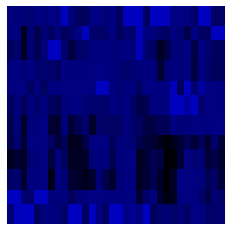

In [ ]:
plt.imshow(test.astype('float32')/255)
plt.axis('off')
plt.figure
plt.savefig('blue.eps', bbox_inches='tight', pad_inches=0.0)

## 1.6 Prediction

In [ ]:
def pred_label(model, X_test):
  y_prob = model.predict(X_test, verbose = 0)
  y_pred = []
  for i in y_prob:
    label = np.argmax(i)
    y_pred.append(label)

  return y_pred

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
optimizer = adam_v2.Adam(learning_rate=0.001)

# 2 Convolution Neural Network

## 2.1 Image Classification

### 2.1.1 Image of Mel-Frequency Spectrogram

In [ ]:
mel_train_array = np.load('/content/drive/MyDrive/machine learning/mel_train_array.npy')
mel_valid_array = np.load('/content/drive/MyDrive/machine learning/mel_valid_array.npy')
mel_test_array = np.load('/content/drive/MyDrive/machine learning/mel_test_array.npy')

In [ ]:
X_train = mel_train_array.astype('float32')/255 
X_valid = mel_valid_array.astype('float32')/255
X_test = mel_test_array.astype('float32')/255

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
X_train, y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 32, 32, 3)

#### 2.1.1.1 VGG with 1 bolck

In [ ]:
model_cnn_mel_img_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding='same',activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation='relu'),
     Dropout(0.2),

     Dense(10, activation='softmax')
])
optimizer = adam_v2.Adam(learning_rate=0.001)
model_cnn_mel_img_1.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_mel_img_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [ ]:
history_cnn_mel_img_1 = model_cnn_mel_img_1.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 15s 8ms/step - loss: 1.0427 - accuracy: 0.6432 - val_loss: 2.2050 - val_accuracy: 0.4347
Epoch 2/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.5666 - accuracy: 0.8060 - val_loss: 2.5427 - val_accuracy: 0.4187
Epoch 3/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.4355 - accuracy: 0.8485 - val_loss: 3.2127 - val_accuracy: 0.4053
Epoch 4/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.3571 - accuracy: 0.8760 - val_loss: 3.0837 - val_accuracy: 0.4314
Epoch 5/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.3037 - accuracy: 0.8927 - val_loss: 3.8990 - val_accuracy: 0.4271
Epoch 6/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.2544 - accuracy: 0.9078 - val_loss: 4.3598 - val_accuracy: 0.4308
Epoch 00006: early stopping


In [ ]:
model1 = pd.DataFrame(history_cnn_mel_img_1.history)
model1.to_csv('/content/drive/MyDrive/machine learning/model1_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_mel_img_1, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model1'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

#### 2.1.1.2 VGG with 3 blocks

In [ ]:
model_cnn_mel_img_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
optimizer = adam_v2.Adam(learning_rate=0.001)

model_cnn_mel_img_3.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn_mel_img_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)         

In [ ]:
history_cnn_mel_img_3 = model_cnn_mel_img_3.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 28s 16ms/step - loss: 1.2400 - accuracy: 0.5700 - val_loss: 2.3125 - val_accuracy: 0.4482
Epoch 2/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.6346 - accuracy: 0.7824 - val_loss: 2.0514 - val_accuracy: 0.4716
Epoch 3/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.4705 - accuracy: 0.8412 - val_loss: 2.3450 - val_accuracy: 0.4800
Epoch 4/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.3832 - accuracy: 0.8674 - val_loss: 2.3805 - val_accuracy: 0.5010
Epoch 5/50
1739/1739 [==============================] - 27s 16ms/step - loss: 0.3407 - accuracy: 0.8834 - val_loss: 2.4996 - val_accuracy: 0.5011
Epoch 6/50
1739/1739 [==============================] - 27s 16ms/step - loss: 0.2982 - accuracy: 0.8961 - val_loss: 2.9656 - val_accuracy: 0.4468
Epoch 7/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.2829 - accuracy: 0.9036 - val_loss: 2.8338 -

In [ ]:
model2 = pd.DataFrame(history_cnn_mel_img_3.history)
model2.to_csv('/content/drive/MyDrive/machine learning/model2_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_mel_img_3, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model2'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

### 2.1.2 Combined image

In [ ]:
train_com = img_combine(mel_train_array, mfcc_train_array, chroma_train_array)
test_com = img_combine(mel_test_array, mfcc_test_array, chroma_test_array)
valid_com = img_combine(mel_valid_array, mfcc_valid_array, chroma_valid_array)

In [ ]:
X_train = train_com.astype('float32')/255
X_test = test_com.astype('float32')/255
X_valid = valid_com.astype('float32')/255

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_com_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
model_cnn_com_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


model_cnn_com_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
history_cnn_com_1 = model_cnn_com_1.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 13s 7ms/step - loss: 1.0097 - accuracy: 0.6559 - val_loss: 2.1720 - val_accuracy: 0.4732
Epoch 2/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.5593 - accuracy: 0.8078 - val_loss: 2.7312 - val_accuracy: 0.4407
Epoch 3/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.4107 - accuracy: 0.8556 - val_loss: 3.2083 - val_accuracy: 0.4370
Epoch 4/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.3279 - accuracy: 0.8847 - val_loss: 2.6858 - val_accuracy: 0.4683
Epoch 5/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.2764 - accuracy: 0.9020 - val_loss: 3.6297 - val_accuracy: 0.4368
Epoch 6/50
1739/1739 [==============================] - 14s 8ms/step - loss: 0.2333 - accuracy: 0.9169 - val_loss: 3.7846 - val_accuracy: 0.4653
Epoch 00006: early stopping


In [ ]:
model3 = pd.DataFrame(history_cnn_com_1.history)
model3.to_csv('/content/drive/MyDrive/machine learning/model3_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_com_1, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model3'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

In [ ]:
model_cnn_com_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_com_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_com_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [ ]:
history_cnn_com_3 = model_cnn_com_3.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 56s 15ms/step - loss: 1.3949 - accuracy: 0.5016 - val_loss: 1.6797 - val_accuracy: 0.4500
Epoch 2/50
1739/1739 [==============================] - 26s 15ms/step - loss: 0.7495 - accuracy: 0.7449 - val_loss: 2.2791 - val_accuracy: 0.4481
Epoch 3/50
1739/1739 [==============================] - 26s 15ms/step - loss: 0.5492 - accuracy: 0.8135 - val_loss: 2.1382 - val_accuracy: 0.4637
Epoch 4/50
1739/1739 [==============================] - 26s 15ms/step - loss: 0.4525 - accuracy: 0.8453 - val_loss: 2.5858 - val_accuracy: 0.4409
Epoch 5/50
1739/1739 [==============================] - 26s 15ms/step - loss: 0.3937 - accuracy: 0.8667 - val_loss: 2.3170 - val_accuracy: 0.4560
Epoch 6/50
1739/1739 [==============================] - 26s 15ms/step - loss: 0.3419 - accuracy: 0.8840 - val_loss: 3.1595 - val_accuracy: 0.4351
Epoch 00006: early stopping


In [ ]:
model4 = pd.DataFrame(history_cnn_com_3.history)
model4.to_csv('/content/drive/MyDrive/machine learning/model4_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_com_3, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model4'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

## 2.2 Classification with Features

- Mel-frequency Spectrogram: 128
- Chromagram: 12
- Tonnetz: 6
- MFCCs: 50

In [ ]:
all_feature_train = np.load('/content/drive/MyDrive/machine learning/all_feature_train.npy')
all_feature_valid = np.load('/content/drive/MyDrive/machine learning/all_feature_valid.npy')
all_feature_test = np.load('/content/drive/MyDrive/machine learning/all_feature_test.npy')

In [ ]:
def add_delta(data):
  two_channel = data[:,:,:,np.newaxis]
  two_channel = np.concatenate((two_channel, np.zeros(np.shape(two_channel))), axis =3)
  for i in range(len(data)):
    feature = two_channel[i,:,:,0].T
    two_channel[i,:,:,1] = librosa.feature.delta(feature).T
  return two_channel

### 2.2.1 Spectrogram features

In [ ]:
mel_train_data = all_feature_train[:,:,:128]
mel_valid_data = all_feature_valid[:,:,:128]
mel_test_data = all_feature_test[:,:,:128]

In [ ]:
X_train = add_delta(mel_train_data)
X_valid = add_delta(mel_valid_data)
X_test = add_delta(mel_test_data)

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label, 10)
y_valid = np_utils.to_categorical(y_valid_label, 10)
y_test = np_utils.to_categorical(y_test_label, 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 128, 2)

In [ ]:
model_cnn_mel_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (41, 128, 2)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
optimizer = adam_v2.Adam(learning_rate=0.001)
model_cnn_mel_1.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn_mel_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 128, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5243008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
history_cnn_mel_1 = model_cnn_mel_1.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 55s 15ms/step - loss: 1.4243 - accuracy: 0.6570 - val_loss: 1.7778 - val_accuracy: 0.5911
Epoch 2/50
1739/1739 [==============================] - 25s 14ms/step - loss: 0.4901 - accuracy: 0.8406 - val_loss: 2.3683 - val_accuracy: 0.5400
Epoch 3/50
1739/1739 [==============================] - 25s 14ms/step - loss: 0.3264 - accuracy: 0.8927 - val_loss: 2.7782 - val_accuracy: 0.5627
Epoch 4/50
1739/1739 [==============================] - 25s 14ms/step - loss: 0.2439 - accuracy: 0.9184 - val_loss: 3.6711 - val_accuracy: 0.5734
Epoch 5/50
1739/1739 [==============================] - 25s 14ms/step - loss: 0.1874 - accuracy: 0.9375 - val_loss: 3.8314 - val_accuracy: 0.5200
Epoch 6/50
1739/1739 [==============================] - 25s 14ms/step - loss: 0.1629 - accuracy: 0.9474 - val_loss: 3.8686 - val_accuracy: 0.5435
Epoch 00006: early stopping


In [ ]:
model5 = pd.DataFrame(history_cnn_mel_1.history)
model5.to_csv('/content/drive/MyDrive/machine learning/model5_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_mel_1, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model5'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

In [ ]:
model_cnn_mel_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 128, 2)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
optimizer = adam_v2.Adam(learning_rate=0.001)
model_cnn_mel_3.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn_mel_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 41, 128, 32)       608       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 64, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 32, 64)       

In [ ]:
history_cnn_mel_3 = model_cnn_mel_3.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 44s 24ms/step - loss: 1.2731 - accuracy: 0.5509 - val_loss: 1.8392 - val_accuracy: 0.4895
Epoch 2/50
1739/1739 [==============================] - 41s 24ms/step - loss: 0.5358 - accuracy: 0.8192 - val_loss: 2.2693 - val_accuracy: 0.4442
Epoch 3/50
1739/1739 [==============================] - 41s 24ms/step - loss: 0.3803 - accuracy: 0.8703 - val_loss: 2.5392 - val_accuracy: 0.4924
Epoch 4/50
1739/1739 [==============================] - 41s 24ms/step - loss: 0.3140 - accuracy: 0.8929 - val_loss: 1.9087 - val_accuracy: 0.6223
Epoch 5/50
1739/1739 [==============================] - 41s 23ms/step - loss: 0.2674 - accuracy: 0.9075 - val_loss: 2.5778 - val_accuracy: 0.5644
Epoch 6/50
1739/1739 [==============================] - 41s 24ms/step - loss: 0.2492 - accuracy: 0.9157 - val_loss: 3.0086 - val_accuracy: 0.5430
Epoch 00006: early stopping


In [ ]:
model6 = pd.DataFrame(history_cnn_mel_3.history)
model6.to_csv('/content/drive/MyDrive/machine learning/model6_history.csv')

In [ ]:
y_pred = pred_label(model_cnn_mel_3, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model6'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

### 2.2.2 All features

In [ ]:
X_train = add_delta(all_feature_train)
X_valid = add_delta(all_feature_valid)
X_test = add_delta(all_feature_test)

In [ ]:
np.save('/content/drive/MyDrive/machine learning/all_delta_train.npy', X_train)
np.save('/content/drive/MyDrive/machine learning/all_delta_valid.npy', X_valid)
np.save('/content/drive/MyDrive/machine learning/all_delta_test.npy', X_test)

In [ ]:
X_train = np.load('/content/drive/MyDrive/machine learning/all_delta_train.npy')
X_valid = np.load('/content/drive/MyDrive/machine learning/all_delta_valid.npy')

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
model_cnn_all_1 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu', input_shape = (41, 190, 2)),
     Conv2D(32, kernel_size = (3, 3), strides=1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),   

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])

model_cnn_all_1.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn_all_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 41, 190, 32)       608       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 190, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 95, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 95, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7782528   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [ ]:
history_cnn_all_1 = model_cnn_all_1.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 64s 20ms/step - loss: 1.7073 - accuracy: 0.6624 - val_loss: 1.6913 - val_accuracy: 0.5535
Epoch 2/50
1739/1739 [==============================] - 34s 20ms/step - loss: 0.5435 - accuracy: 0.8146 - val_loss: 1.8002 - val_accuracy: 0.5410
Epoch 3/50
1739/1739 [==============================] - 34s 19ms/step - loss: 0.3965 - accuracy: 0.8638 - val_loss: 2.4911 - val_accuracy: 0.4976
Epoch 4/50
1739/1739 [==============================] - 34s 19ms/step - loss: 0.3045 - accuracy: 0.8958 - val_loss: 2.4149 - val_accuracy: 0.5361
Epoch 5/50
1739/1739 [==============================] - 34s 20ms/step - loss: 0.2605 - accuracy: 0.9130 - val_loss: 2.2310 - val_accuracy: 0.5773
Epoch 6/50
1739/1739 [==============================] - 34s 19ms/step - loss: 0.2176 - accuracy: 0.9259 - val_loss: 2.4899 - val_accuracy: 0.5678
Epoch 00006: early stopping


In [ ]:
model7 = pd.DataFrame(history_cnn_all_1.history)
model7.to_csv('/content/drive/MyDrive/machine learning/model7_history.csv')

In [ ]:
model_cnn_all_1.save('/content/drive/MyDrive/machine learning/cnn_all_1.h5')

In [ ]:
X_test = np.load('/content/drive/MyDrive/machine learning/all_delta_test.npy')
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
model_cnn_all_1 = load_model('/content/drive/MyDrive/machine learning/cnn_all_1.h5')

In [ ]:
y_pred = pred_label(model_cnn_all_1, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model7'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

In [ ]:
model_cnn_all_3 = Sequential([
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 190, 2)),
     Conv2D(32, kernel_size = (3, 3), strides = 1, padding= 'same', activation='relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'),
     Conv2D(64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2),  

     Conv2D(128, kernel_size=(3, 3), strides = 1, padding = 'same', activation='relu'),
     Conv2D(128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu'), 
     MaxPooling2D(pool_size = (2, 2)),
     Dropout(0.2), 

     Flatten(),

     Dense(128, activation = 'relu'),
     Dropout(0.2),

     Dense(10, activation = 'softmax')
])
     
model_cnn_all_3.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_cnn_all_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 41, 190, 32)       608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 190, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 95, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 95, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 95, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 47, 64)        0

In [ ]:
history_cnn_all_3 = model_cnn_all_3.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 86s 33ms/step - loss: 1.2530 - accuracy: 0.5664 - val_loss: 1.8451 - val_accuracy: 0.5091
Epoch 2/50
1739/1739 [==============================] - 55s 31ms/step - loss: 0.6420 - accuracy: 0.7839 - val_loss: 1.8244 - val_accuracy: 0.5233
Epoch 3/50
1739/1739 [==============================] - 55s 32ms/step - loss: 0.4462 - accuracy: 0.8465 - val_loss: 2.5116 - val_accuracy: 0.4992
Epoch 4/50
1739/1739 [==============================] - 54s 31ms/step - loss: 0.3539 - accuracy: 0.8770 - val_loss: 2.9290 - val_accuracy: 0.4881
Epoch 5/50
1739/1739 [==============================] - 55s 31ms/step - loss: 0.3050 - accuracy: 0.8962 - val_loss: 1.7928 - val_accuracy: 0.6005
Epoch 6/50
1739/1739 [==============================] - 55s 31ms/step - loss: 0.2734 - accuracy: 0.9069 - val_loss: 2.5457 - val_accuracy: 0.5519
Epoch 7/50
1739/1739 [==============================] - 54s 31ms/step - loss: 0.2360 - accuracy: 0.9186 - val_loss: 2.1659 -

In [ ]:
model8 = pd.DataFrame(history_cnn_all_3.history)
model8.to_csv('/content/drive/MyDrive/machine learning/model8_history.csv')

In [ ]:
model_cnn_all_3.save('/content/drive/MyDrive/machine learning/cnn_all_3.h5')

In [ ]:
X_test = np.load('/content/drive/MyDrive/machine learning/all_delta_test.npy')
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
model_cnn_all_3 = load_model('/content/drive/MyDrive/machine learning/cnn_all_3.h5')

In [ ]:
y_pred = pred_label(model_cnn_all_3, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model8'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

# 3 Convolution Recurrent Neural Network

## 3.1 with Mel-Spectrogram

In [ ]:
all_feature_train = np.load('/content/drive/MyDrive/machine learning/all_feature_train.npy')
all_feature_valid = np.load('/content/drive/MyDrive/machine learning/all_feature_valid.npy')
all_feature_test = np.load('/content/drive/MyDrive/machine learning/all_feature_test.npy')

In [ ]:
mel_train_data = all_feature_train[:,:,:128]
mel_valid_data = all_feature_valid[:,:,:128]
mel_test_data = all_feature_test[:,:,:128]

In [ ]:
X_train = mel_train_data[:,:,:, np.newaxis]
X_valid = mel_valid_data[:,:,:, np.newaxis]

X_test = mel_test_data[:,:,:, np.newaxis]

In [ ]:
y_train_label = train_meta_split['label']
y_valid_label = valid_meta_split['label']
y_test_label = test_meta_split['label']

In [ ]:
y_train = np_utils.to_categorical(y_train_label, 10)
y_valid = np_utils.to_categorical(y_valid_label, 10)
y_test = np_utils.to_categorical(y_test_label, 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 128, 1)

In [ ]:
model_crnn_mel = Sequential([
     Conv2D(16, kernel_size= (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 128,1)),
     MaxPooling2D(pool_size = (1, 4)),
     Dropout(0.1),   

     Conv2D(32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
     MaxPooling2D(pool_size = (1, 4)),
     Dropout(0.1),  

     Conv2D(64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
     MaxPooling2D(pool_size = (1, 5)),
     Dropout(0.1),

     Reshape([41, 64]),

     GRU(32),
     Dropout(0.2),

     Flatten(),

     Dense(128, activation='relu'),
     Dense(10, activation='softmax')
     
])

model_crnn_mel.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_crnn_mel.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 41, 128, 16)       160       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 41, 32, 16)        0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 41, 32, 16)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 41, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 41, 8, 32)         0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 41, 8, 32)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 41, 8, 64)       

In [ ]:
history_crnn_mel = model_crnn_mel.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 61s 17ms/step - loss: 1.5485 - accuracy: 0.4381 - val_loss: 1.7845 - val_accuracy: 0.4486
Epoch 2/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.8738 - accuracy: 0.7096 - val_loss: 1.6503 - val_accuracy: 0.5323
Epoch 3/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.6784 - accuracy: 0.7760 - val_loss: 1.7046 - val_accuracy: 0.5191
Epoch 4/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.5735 - accuracy: 0.8132 - val_loss: 1.7731 - val_accuracy: 0.5709
Epoch 5/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.5132 - accuracy: 0.8326 - val_loss: 1.7416 - val_accuracy: 0.5400
Epoch 6/50
1739/1739 [==============================] - 29s 17ms/step - loss: 0.4766 - accuracy: 0.8444 - val_loss: 1.7069 - val_accuracy: 0.5780
Epoch 7/50
1739/1739 [==============================] - 29s 17ms/step - loss: 0.4519 - accuracy: 0.8514 - val_loss: 1.7715 -

In [ ]:
model9 = pd.DataFrame(history_crnn_mel.history)
model9.to_csv('/content/drive/MyDrive/machine learning/model9_history.csv')

In [ ]:
y_pred = pred_label(model_crnn_mel, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model9'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

In [ ]:
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

## 3.2 with All Features



In [ ]:
all_feature_train = np.load('/content/drive/MyDrive/machine learning/all_feature_train.npy') 
all_feature_valid = np.load('/content/drive/MyDrive/machine learning/all_feature_valid.npy')
all_feature_test = np.load('/content/drive/MyDrive/machine learning/all_feature_test.npy') 

In [ ]:
X_train = all_feature_train[:,:,:,np.newaxis]
X_valid = all_feature_valid[:,:,:,np.newaxis]
X_test = all_feature_test[:,:,:,np.newaxis]

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 190, 1)

In [ ]:
model_crnn_all = Sequential([
     Conv2D(16, kernel_size= (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (41, 190,1)),
     MaxPooling2D(pool_size = (1, 5)),
     Dropout(0.1),   

     Conv2D(32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
     MaxPooling2D(pool_size = (1, 4)),
     Dropout(0.1),  

     Conv2D(64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu'),
     MaxPooling2D(pool_size = (1, 5)),
     Dropout(0.1),

     Reshape([41, 64]),

     GRU(32),
     Dropout(0.2),

     Flatten(),

     Dense(128, activation='relu'),
     Dense(10, activation='softmax')
     
])

model_crnn_all.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_crnn_all.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 41, 190, 16)       160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 41, 38, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 41, 38, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 41, 38, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 41, 9, 32)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 41, 9, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 41, 9, 64)        

In [ ]:
history_crnn_all = model_crnn_all.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data = (X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 67s 20ms/step - loss: 1.5326 - accuracy: 0.4439 - val_loss: 1.9111 - val_accuracy: 0.3915
Epoch 2/50
1739/1739 [==============================] - 34s 20ms/step - loss: 0.9372 - accuracy: 0.6866 - val_loss: 1.5208 - val_accuracy: 0.5511
Epoch 3/50
1739/1739 [==============================] - 35s 20ms/step - loss: 0.7103 - accuracy: 0.7680 - val_loss: 1.8368 - val_accuracy: 0.5509
Epoch 4/50
1739/1739 [==============================] - 35s 20ms/step - loss: 0.5867 - accuracy: 0.8069 - val_loss: 2.1586 - val_accuracy: 0.5753
Epoch 5/50
1739/1739 [==============================] - 35s 20ms/step - loss: 0.5224 - accuracy: 0.8292 - val_loss: 1.7125 - val_accuracy: 0.6103
Epoch 6/50
1739/1739 [==============================] - 35s 20ms/step - loss: 0.4742 - accuracy: 0.8434 - val_loss: 1.6958 - val_accuracy: 0.5996
Epoch 7/50
1739/1739 [==============================] - 35s 20ms/step - loss: 0.4420 - accuracy: 0.8529 - val_loss: 1.5046 -

In [ ]:
model10 = pd.DataFrame(history_crnn_all.history)
model10.to_csv('/content/drive/MyDrive/machine learning/model10_history.csv')

In [ ]:
y_pred = pred_label(model_crnn_all, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model10'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

# 4 Parallel CNN-RNN Model

In [ ]:
def parallel_cnn_rnn(model_input):
  print('Builing model...')
  layer = model_input

  ## CNN block
  conv_1 = Conv2D(16, (3, 1), strides=1, padding = 'same', activation='relu')(layer)
  pool_1 = MaxPooling2D((2,2))(conv_1)

  conv_2 = Conv2D(32, (3, 1), strides=1, padding = 'same', activation='relu')(pool_1)
  pool_2 = MaxPooling2D((2,2))(conv_2)

  conv_3 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_2)
  pool_3 = MaxPooling2D((2,2))(conv_3)

  conv_4 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_3)
  pool_4 = MaxPooling2D((2,2))(conv_4)

  conv_5 = Conv2D(64, (3, 1), strides=1, padding = 'same', activation='relu')(pool_4)
  pool_5 = MaxPooling2D((2,2))(conv_5)

  flatten_1 = Flatten()(pool_5)

  ## Bi-RNN block
  pool_lstm1 = MaxPooling2D((4,2))(layer)
  squeezed = Lambda(lambda x: keras.backend.squeeze(x, axis= -1))(pool_lstm1)
  lstm = Bidirectional(GRU(32))(squeezed)

  ## Concat two output
  concat = concatenate([flatten_1, lstm], axis=-1)
  output = Dense(10, activation = 'softmax')(concat)

  model_output = output

  model = Model(model_input, model_output)

  optimizer = adam_v2.Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  
  return model

## 4.1 with Mel-Frequency Spectrogram

In [ ]:
model_input_mel = Input((41,128,1))
model_pcrnn_mel = parallel_cnn_rnn(model_input_mel)

Builing model...
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 41, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 41, 128, 16)  64          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 20, 64, 16)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 20, 64, 32)   1568        max_pooling2d_18[0][0]           
___________________________________________________________________________

In [ ]:
X_train = mel_train_data
X_valid = mel_valid_data

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 128, 1)

In [ ]:
history_pcrnn_mel = model_pcrnn_mel.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 28s 14ms/step - loss: 1.4456 - accuracy: 0.4902 - val_loss: 1.6368 - val_accuracy: 0.4198
Epoch 2/50
1739/1739 [==============================] - 24s 14ms/step - loss: 1.0635 - accuracy: 0.6407 - val_loss: 1.4912 - val_accuracy: 0.4908
Epoch 3/50
1739/1739 [==============================] - 24s 14ms/step - loss: 0.9084 - accuracy: 0.6977 - val_loss: 1.5244 - val_accuracy: 0.4952
Epoch 4/50
1739/1739 [==============================] - 24s 14ms/step - loss: 0.7976 - accuracy: 0.7328 - val_loss: 1.4759 - val_accuracy: 0.5280
Epoch 5/50
1739/1739 [==============================] - 24s 14ms/step - loss: 0.7249 - accuracy: 0.7585 - val_loss: 1.6314 - val_accuracy: 0.5208
Epoch 6/50
1739/1739 [==============================] - 24s 14ms/step - loss: 0.6630 - accuracy: 0.7790 - val_loss: 1.5221 - val_accuracy: 0.5808
Epoch 7/50
1739/1739 [==============================] - 24s 14ms/step - loss: 0.6215 - accuracy: 0.7924 - val_loss: 1.4871 -

In [ ]:
model11 = pd.DataFrame(history_pcrnn_mel.history)
model11.to_csv('/content/drive/MyDrive/machine learning/model11_history.csv')

In [ ]:
mel_test_data = all_feature_test[:,:,:128]
X_test = mel_test_data[:,:,:, np.newaxis]

In [ ]:
y_pred = pred_label(model_pcrnn_mel, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model11'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

## 4.2 with All Features

In [ ]:
X_train = all_feature_train[:,:,:,np.newaxis]
X_valid = all_feature_valid[:,:,:,np.newaxis]
X_test = all_feature_test[:,:,:,np.newaxis]

In [ ]:
y_train = np_utils.to_categorical(train_meta_split['label'], 10)
y_valid = np_utils.to_categorical(valid_meta_split['label'], 10)
y_test = np_utils.to_categorical(test_meta_split['label'], 10)

In [ ]:
X_train,y_train = shuffle(X_train, y_train) 
X_valid, y_valid = shuffle(X_valid, y_valid)

In [ ]:
X_train.shape

(27809, 41, 190, 1)

In [ ]:
model_input_all = Input((41,190,1))
model_pcrnn_all = parallel_cnn_rnn(model_input_all)

Builing model...
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41, 190, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 41, 190, 16)  64          input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 20, 95, 16)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 20, 95, 32)   1568        max_pooling2d_24[0][0]           
___________________________________________________________________________

In [ ]:
history_pcrnn_all = model_pcrnn_all.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_valid, y_valid), verbose = 1, callbacks = [es])

Epoch 1/50
1739/1739 [==============================] - 33s 17ms/step - loss: 1.4946 - accuracy: 0.4805 - val_loss: 1.4980 - val_accuracy: 0.4391
Epoch 2/50
1739/1739 [==============================] - 27s 15ms/step - loss: 1.0292 - accuracy: 0.6546 - val_loss: 1.5880 - val_accuracy: 0.4827
Epoch 3/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.8794 - accuracy: 0.7066 - val_loss: 1.4317 - val_accuracy: 0.5366
Epoch 4/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.7652 - accuracy: 0.7447 - val_loss: 1.5331 - val_accuracy: 0.5270
Epoch 5/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.6928 - accuracy: 0.7688 - val_loss: 1.4907 - val_accuracy: 0.5544
Epoch 6/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.6104 - accuracy: 0.7948 - val_loss: 1.4358 - val_accuracy: 0.5678
Epoch 7/50
1739/1739 [==============================] - 28s 16ms/step - loss: 0.5727 - accuracy: 0.8065 - val_loss: 1.3944 -

In [ ]:
model12 = pd.DataFrame(history_pcrnn_all.history)
model12.to_csv('/content/drive/MyDrive/machine learning/model12_history.csv')

In [ ]:
y_pred = pred_label(model_pcrnn_all, X_test)
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')
prediction['model12'] = y_pred
prediction.to_csv('/content/drive/MyDrive/machine learning/prediction.csv')

# 5 Result visualization

## 5.1 Result Summary

In [ ]:
test_fold = ['fold7', 'fold8', 'fold9', 'fold10']
prediction['fold'] = test_meta_split['fold']
prediction['label'] = test_meta_split['label']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
acc_dict = defaultdict(list)
for i in test_fold:
  y_true = prediction[prediction['fold'] == i]['label']
  for n in range(1,13):
    m = 'model' + str(n)
    y_pred = prediction[prediction['fold'] == i][m]
    a = round(accuracy_score(y_true, y_pred),2)
    acc_dict[i].append(a)

In [ ]:
accuracy_table = pd.DataFrame(acc_dict)

In [ ]:
mean = accuracy_table.mean(axis = 1)
std = accuracy_table.std(axis = 1)

In [ ]:
accuracy_table['Average'] = round(mean,4)
accuracy_table['Standard Deviation'] = round(std,4)

In [ ]:
nn = []
for i in range(1,13):
  m = 'Model ' + str(i)
  nn.append(m)

In [ ]:
accuracy_table.index = nn

## 5.2 Accuracy and Loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


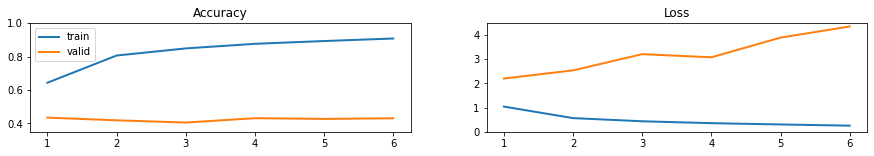

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model1_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model1.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


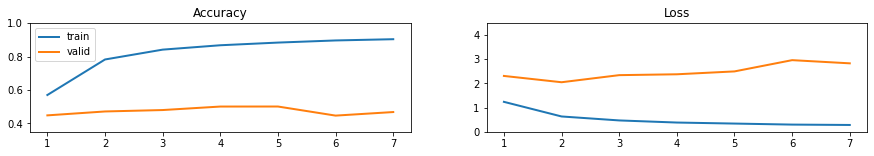

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model2_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model2.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


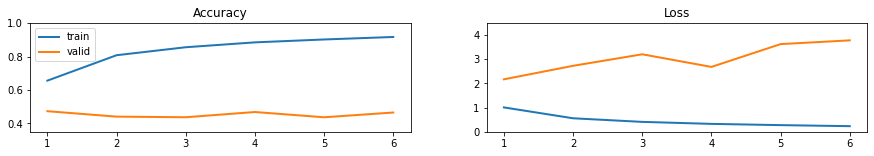

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model3_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model3.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


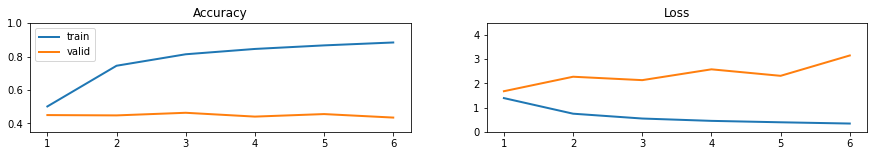

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model4_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model4.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


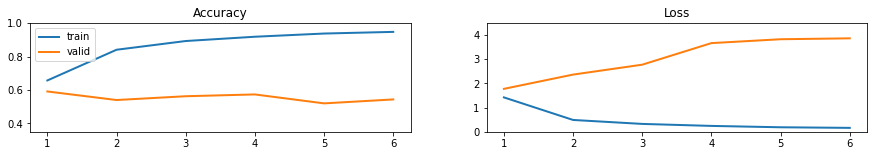

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model5_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model5.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


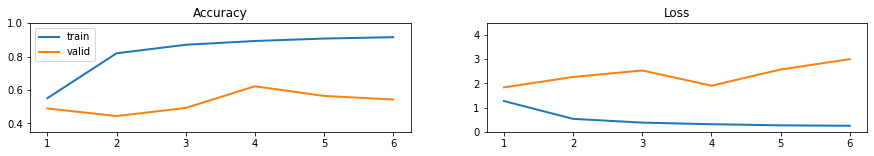

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model6_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model6.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


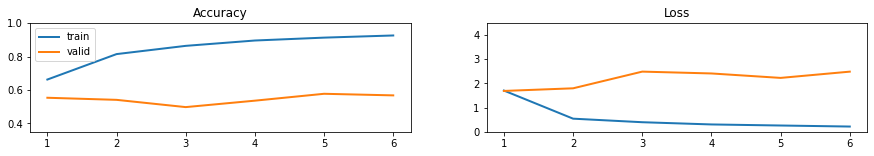

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model7_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model7.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


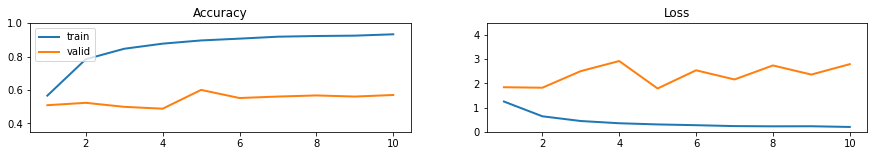

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model8_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model8.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


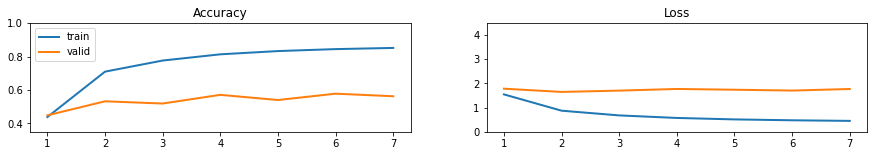

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model9_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model9.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


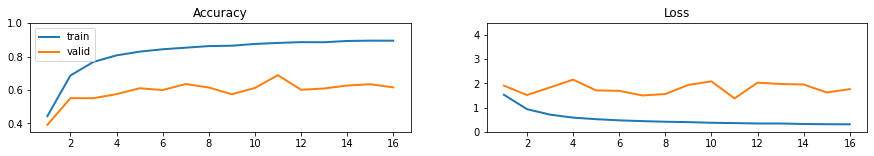

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model10_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model10.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


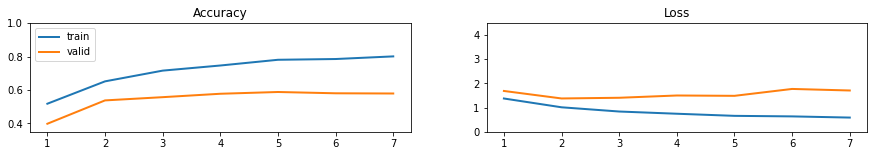

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model11_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model11.eps', bbox_inches='tight', pad_inches=0.0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


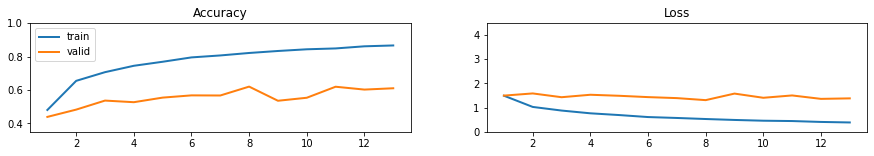

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/machine learning/model12_history.csv')
history.index = range(1,len(history)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,2))

ax1.plot(history['accuracy'], linewidth = 2)
ax1.plot(history['val_accuracy'], linewidth = 2)
ax1.legend(['train', 'valid'], loc='upper left')  
ax1.set_ylim([0.35, 1])
ax1.set_title('Accuracy')  

ax2.plot(history['loss'], linewidth = 2)
ax2.plot(history['val_loss'], linewidth = 2)
ax2.set_title('Loss')
ax2.set_ylim([0, 4.5]) 

plt.figure
plt.savefig('model12.eps', bbox_inches='tight', pad_inches=0.0)

## 5.3 Error analyis

In [ ]:
prediction = pd.read_csv('/content/drive/MyDrive/machine learning/prediction.csv')

In [ ]:
y_true = test_meta_split['label']

In [ ]:
recall = defaultdict(list)
target_names = ['Air conditioner', 'Car horn', 'Children playing', 'Dog bark', 'Drilling', 'Enginge idling', 'Gun shot', 'Jackhammer', 'Siren', 'Street music']
for n in range(1,13):
  m = 'model' + str(n)
  y_pred = prediction[m]
  y_true = test_meta_split['label']
  cr = classification_report(y_true, y_pred, target_names = target_names, output_dict = True)
  for i in target_names:
    recall[m].append(round(cr[i]['recall'], 2))

In [ ]:
recall = pd.DataFrame(recall)

In [ ]:
recall.index = target_names

In [ ]:
name = []
for i in range(1,13):
  n = 'Model ' + str(i)
  nn = name.append(n)

In [ ]:
recall.columns = name

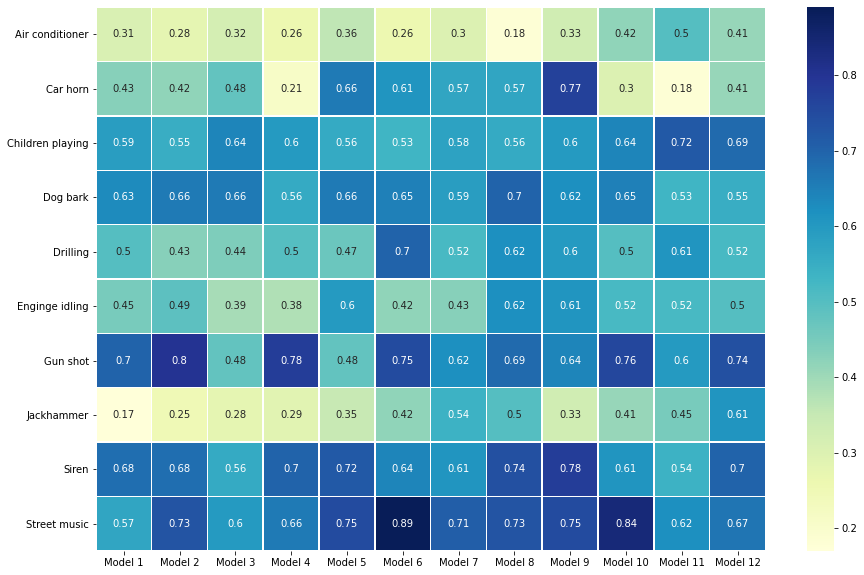

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(recall, annot=True, annot_kws={"size": 10}, fmt='g', linewidths=.5, cmap="YlGnBu")
plt.figure
plt.savefig('recall.eps', bbox_inches='tight', pad_inches=0.0)
# YlGnBu

In [ ]:
def plot_cm(y_true, y_pred):  # true as row, pred as column
  label_name = ["aircon", "horn", "child", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
  y_t = []
  for i in y_true:
    y_t.append(label_name[i])
  y_p = []
  for j in y_pred:
    y_p.append(label_name[j])
  cm = confusion_matrix(y_t, y_p, labels=label_name)
  plt.figure(figsize = (10,8))
  df_cm = pd.DataFrame(cm, label_name, label_name)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, cmap="magma", vmin=0, vmax=2100)

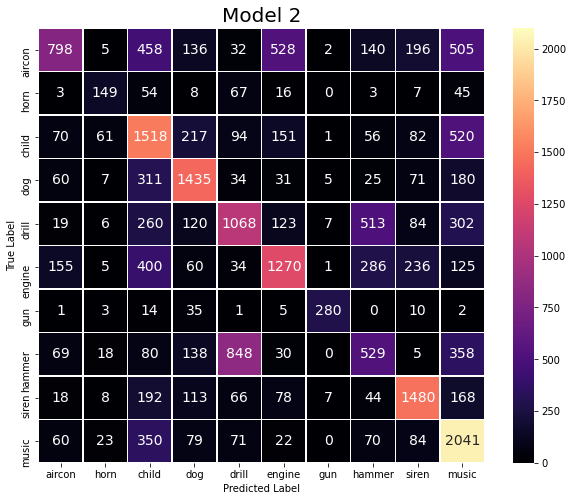

In [ ]:
plot_cm(y_true, prediction['model2'])
plt.title("Model 2", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cate1.eps', bbox_inches='tight', pad_inches=0.0)

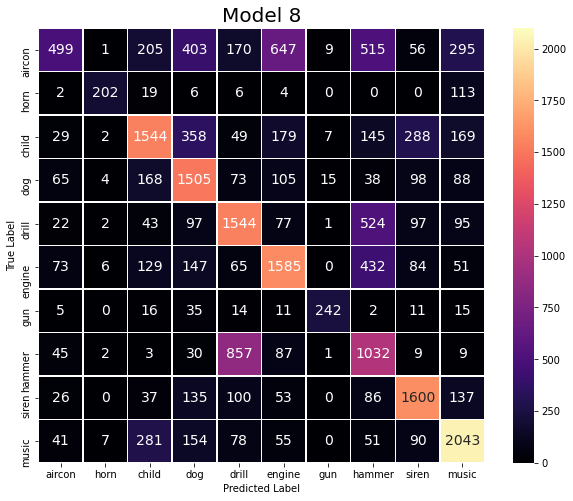

In [ ]:
plot_cm(y_true, prediction['model8'])
plt.title("Model 8", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cate2.eps', bbox_inches='tight', pad_inches=0.0)

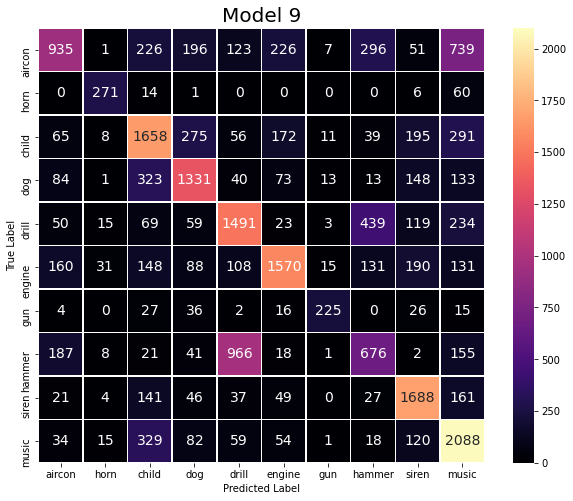

In [ ]:
plot_cm(y_true, prediction['model9'])
plt.title("Model 9", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cate3.eps', bbox_inches='tight', pad_inches=0.0)

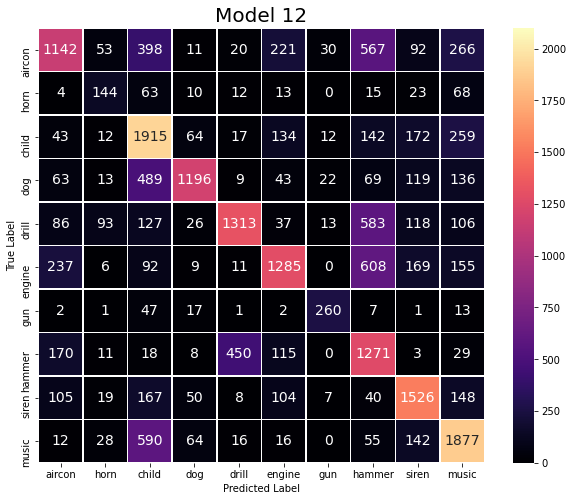

In [ ]:
plot_cm(y_true, prediction['model12'])
plt.title("Model 12", fontsize=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cate4.eps', bbox_inches='tight', pad_inches=0.0)